In [12]:
import pandas as pd
%matplotlib inline

In [11]:
from yellowbrick.features.radviz import *
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header=None)
data.rename(columns={57:'is_spam'}, inplace=True)

In [15]:
features = [col for col in data.columns if col != 'is_spam'][:5]
# Extract the numpy arrays from the data frame
X = data[features].as_matrix()
y = data.is_spam.as_matrix()

/usr/local/var/pyenv/versions/3.5.2/envs/yb-dev/lib/python3.5/site-packages/ipykernel_launcher.py:118: RuntimeWarning: invalid value encountered in true_divide


array([[ 0.  ,  0.64,  0.64,  0.  ,  0.32],
       [ 0.21,  0.28,  0.5 ,  0.  ,  0.14],
       [ 0.06,  0.  ,  0.71,  0.  ,  1.23],
       ..., 
       [ 0.3 ,  0.  ,  0.3 ,  0.  ,  0.  ],
       [ 0.96,  0.  ,  0.  ,  0.  ,  0.32],
       [ 0.  ,  0.  ,  0.65,  0.  ,  0.  ]])

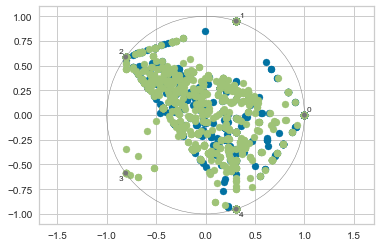

In [26]:

# Test the visualizer
visualizer = RadialVisualizer()
visualizer.fit_transform(X, y)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from yellowbrick.features.base import DataVisualizer
from yellowbrick.exceptions import YellowbrickTypeError
from yellowbrick.style.colors import resolve_colors, get_color_cycle

class RadialVisualizer(DataVisualizer):
    """
    RadViz is a multivariate data visualization algorithm that plots each
    axis uniformely around the circumference of a circle then plots points on
    the interior of the circle such that the point normalizes its values on
    the axes from the center to each arc.

    Parameters
    ----------

    ax : matplotlib Axes, default: None
        The axis to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    features : list, default: None
        a list of feature names to use
        If a DataFrame is passed to fit and features is None, feature
        names are selected as the columns of the DataFrame.

    classes : list, default: None
        a list of class names for the legend
        If classes is None and a y value is passed to fit then the classes
        are selected from the target vector.

    color : list or tuple, default: None
        optional list or tuple of colors to colorize lines
        Use either color to colorize the lines on a per class basis or
        colormap to color them on a continuous scale.

    colormap : string or cmap, default: None
        optional string or matplotlib cmap to colorize lines
        Use either color to colorize the lines on a per class basis or
        colormap to color them on a continuous scale.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------

    >>> visualizer = RadViz()
    >>> visualizer.fit(X, y)
    >>> visualizer.transform(X)
    >>> visualizer.poof()

    Notes
    -----
    These parameters can be influenced later on in the visualization
    process, but can and should be set as early as possible.
    """

    def __init__(self, ax=None, features=None, classes=None, color=None,
                 colormap=None, **kwargs):
        super(RadialVisualizer, self).__init__(
            ax, features, classes, color, colormap, **kwargs
        )

    @staticmethod
    def normalize(X):
        """
        MinMax normalization to fit a matrix in the space [0,1] by column.
        """
        a = X.min(axis=0)
        b = X.max(axis=0)
        return (X - a[np.newaxis, :]) / ((b - a)[np.newaxis, :])

    def draw(self, X, y, **kwargs):
        """
        Called from the fit method, this method creates the radviz canvas and
        draws each instance as a class or target colored point, whose location
        is determined by the feature data set.
        """

        # Get the shape of the data
        nrows, ncols = X.shape

        # Set the axes limits
        self.ax.set_xlim([-1,1])
        self.ax.set_ylim([-1,1])

        # Create the colors
        # TODO: Allow both colormap, listed colors, and palette definition
        # TODO: Make this an independent function or property for override!
        # color_values = resolve_colors(
        #     num_colors=len(self.classes_), colormap=self.colormap, color=self.color
        # )
        color_values = get_color_cycle()
        colors = dict(zip(self.classes_, color_values))

        # Create a data structure to hold scatter plot representations
        to_plot = {}
        for kls in self.classes_:
            to_plot[kls] = [[], []]

        # Compute the arcs around the circumference for each feature axis
        # TODO: make this an independent function for override
        s = np.array([
                (np.cos(t), np.sin(t))
                for t in [
                    2.0 * np.pi * (i / float(ncols))
                    for i in range(ncols)
                ]
            ])

        # Compute the locations of the scatter plot for each class
        # Normalize the data first to plot along the 0, 1 axis
        for i, row in enumerate(self.normalize(X)):
            row_ = np.repeat(np.expand_dims(row, axis=1), 2, axis=1)
            xy   = (s * row_).sum(axis=0) / row.sum()
            kls = self.classes_[y[i]]

            to_plot[kls][0].append(xy[0])
            to_plot[kls][1].append(xy[1])

        # Add the scatter plots from the to_plot function
        # TODO: store these plots to add more instances to later
        # TODO: make this a separate function
        for i, kls in enumerate(self.classes_):
            self.ax.scatter(to_plot[kls][0], to_plot[kls][1], color=colors[kls], label=str(kls), **kwargs)

        # Add the circular axis path
        # TODO: Make this a seperate function (along with labeling)
        self.ax.add_patch(patches.Circle((0.0, 0.0), radius=1.0, facecolor='none', edgecolor='grey', linewidth=.5 ))

        # Add the feature names
        for xy, name in zip(s, self.features_):
            # Add the patch indicating the location of the axis
            self.ax.add_patch(patches.Circle(xy, radius=0.025, facecolor='#777777'))

            # Add the feature names offset around the axis marker
            if xy[0] < 0.0 and xy[1] < 0.0:
                self.ax.text(xy[0] - 0.025, xy[1] - 0.025, name, ha='right', va='top', size='small')
            elif xy[0] < 0.0 and xy[1] >= 0.0:
                self.ax.text(xy[0] - 0.025, xy[1] + 0.025, name, ha='right', va='bottom', size='small')
            elif xy[0] >= 0.0 and xy[1] < 0.0:
                self.ax.text(xy[0] + 0.025, xy[1] - 0.025, name, ha='left', va='top', size='small')
            elif xy[0] >= 0.0 and xy[1] >= 0.0:
                self.ax.text(xy[0] + 0.025, xy[1] + 0.025, name, ha='left', va='bottom', size='small')

        self.ax.axis('equal')

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        # Set the title
        self.set_title(
            'RadViz for {} Features'.format(len(self.features_))
        )

        # Remove the ticks from the graph
        self.ax.set_yticks([])
        self.ax.set_xticks([])

        # Add the legend
        self.ax.legend(loc='best')
